**Описание проекта**  
 Компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**  

*Тариф «Смарт»*  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  

*Тариф «Ультра»*  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  

**Примечание:**  
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.  
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.  

##  **Обзор данных**

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sbn 
from scipy import stats as st
sns.set()
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = 100
 


In [2]:
users = pd.read_csv('/datasets/users.csv') 
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

### Таблица users (информация о пользователях)

In [3]:
display(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


 Вывод по таблице:  
user_id — уникальный идентификатор пользователя  
first_name — имя пользователя  
last_name — фамилия пользователя  
age — возраст пользователя (годы)  
reg_date — дата подключения тарифа (день, месяц, год)  
churn_date — дата прекращения пользования тарифом (если значение пропущено,то тариф ещё действовал на момент выгрузки данных)  
38 пользователей из 500 уже не пользуются тарифом   
city — город проживания пользователя  
tariff — название тарифного плана    

Все столбцы с датой буду приводить к одному формату

In [5]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')

### Таблица calls (информация о звонках):

In [6]:
display(calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Вывод по таблице:    
id — уникальный номер звонка  
call_date — дата звонка  
duration — длительность звонка в минутах  
user_id — идентификатор пользователя, сделавшего звонок  

Необходимо округлить время длительности звонка  


In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls['id'] = calls['id'].astype('int')

In [9]:
#Округляем длительность звонков
calls['duration'] = np.ceil(calls['duration']).astype('int')


### Таблица messages (информация о сообщениях):

In [10]:
display(messages)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Вывод:  
id — уникальный номер сообщения  
message_date — дата сообщения  
user_id — идентификатор пользователя, отправившего сообщение  


In [12]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

### Таблица internet (информация об интернет-сессиях):

In [13]:
display(internet)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,"1,246.32",2018-11-26,1499


In [14]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
internet['id'] = internet['id'].astype('int')

id — уникальный номер сессии  
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
session_date — дата интернет-сессии  
user_id — идентификатор пользователя  

### Таблица tariffs (информация о тарифах):

In [15]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


* tariff_name — название тарифа  
* rub_monthly_fee — ежемесячная абонентская плата в рублях  
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
* messages_included — количество сообщений в месяц, включённых в абонентскую плату  
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета  
(например, если в тарифе 100 минут разговора в месяц, то со   101 минуты будет взиматься плата)  
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета  
(1 гигабайт = 1024 мегабайта)

## **Подготовка данных**

Согласно инструкции нам нужно посчитать для каждого пользователя:  
* количество сделанных звонков и израсходованных минут разговора по месяцам;  
* количество отправленных сообщений по месяцам;  
* объем израсходованного интернет-трафика по месяцам;  
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков,  
сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату,  
соответствующую тарифному плану).

### Calls

In [16]:
#количество сделанных звонков и израсходованных минут разговора по месяцам
calls['month'] = calls['call_date'].dt.month
calls_df = calls.groupby(['user_id','month']).agg({'duration':'sum', 'id':'count'}).reset_index().rename(columns={'duration':'total_minute','id':'total_calls'})
display(calls_df)

,user_id,month,total_minute,total_calls
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
...,...,...,...,...
3169,1498,10,247,41
3170,1499,9,70,9
3171,1499,10,449,68
3172,1499,11,612,74


### Messages

In [17]:
#количество отправленных сообщений по месяцам;
messages['month'] = messages['message_date'].dt.month
messages_df = messages.groupby(['user_id','month']).agg({'id':'count'}).reset_index().rename(columns={'id':'total_sms'})
display(messages_df)

,user_id,month,total_sms
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


### Internet

In [18]:
internet['month'] = internet['session_date'].dt.month

In [19]:
#объем израсходованного интернет-трафика по месяцам
internet['mb_used'] = internet['mb_used']/1024
internet_df = internet.groupby(['user_id','month']).agg({'mb_used':'sum','id':'count'}).reset_index().rename(columns={'mb_used':'total_mb','id':'total_session'})
np.floor(internet['mb_used'])
display(internet_df)

,user_id,month,total_mb,total_session
0,1000,5,2.20,5
1,1000,6,22.69,49
2,1000,7,13.68,29
3,1000,8,13.73,29
4,1000,9,14.23,27
...,...,...,...,...
3198,1498,10,20.10,59
3199,1499,9,1.80,5
3200,1499,10,17.37,58
3201,1499,11,17.54,49


### Объединяем таблицы

In [20]:
#Соединили таблицы 
df = calls_df.merge(messages_df, on=['user_id','month'], how='outer')
df = df.merge(internet_df, on=['user_id','month'], how = 'outer')
display(df)



,user_id,month,total_minute,total_calls,total_sms,total_mb,total_session
0,1000,5,159.00,22.00,22.00,2.20,5.00
1,1000,6,172.00,43.00,60.00,22.69,49.00
2,1000,7,340.00,47.00,75.00,13.68,29.00
3,1000,8,408.00,52.00,81.00,13.73,29.00
4,1000,9,466.00,58.00,57.00,14.23,27.00
...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.00,16.80,63.00
3210,1489,10,NaN,NaN,21.00,19.10,63.00
3211,1489,11,NaN,NaN,20.00,17.08,55.00
3212,1489,12,NaN,NaN,35.00,16.92,51.00


In [21]:
tariffs.rename(columns={'tariff_name':'tariff'}, inplace=True)

In [22]:
#Соединили users,tariffs
users_tariffs = users.merge(tariffs,on = ['tariff'],how ='left')
display(users_tariffs)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,1000,30720,3000,1950,150,1,1
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,50,15360,500,550,200,3,3
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,50,15360,500,550,200,3,3
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3


In [23]:
#Объединяем в одну таблицу
df = df.merge(users_tariffs,on = ['user_id'],how ='outer').reset_index()
display(df)

,index,user_id,month,total_minute,total_calls,total_sms,total_mb,total_session,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,0,1000,5.00,159.00,22.00,22.00,2.20,5.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1,1000,6.00,172.00,43.00,60.00,22.69,49.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,2,1000,7.00,340.00,47.00,75.00,13.68,29.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,3,1000,8.00,408.00,52.00,81.00,13.73,29.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,4,1000,9.00,466.00,58.00,57.00,14.23,27.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3211,1489,10.00,NaN,NaN,21.00,19.10,63.00,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,3212,1489,11.00,NaN,NaN,20.00,17.08,55.00,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3213,3213,1489,12.00,NaN,NaN,35.00,16.92,51.00,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3214,3214,1128,NaN,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  3216 non-null   int64         
 1   user_id                3216 non-null   int64         
 2   month                  3214 non-null   float64       
 3   total_minute           3174 non-null   float64       
 4   total_calls            3174 non-null   float64       
 5   total_sms              2717 non-null   float64       
 6   total_mb               3203 non-null   float64       
 7   total_session          3203 non-null   float64       
 8   age                    3216 non-null   int64         
 9   churn_date             189 non-null    datetime64[ns]
 10  city                   3216 non-null   object        
 11  first_name             3216 non-null   object        
 12  last_name              3216 non-null   object        
 13  reg

In [25]:
# Количество пропусков
df.isna().sum()

index                       0
user_id                     0
month                       2
total_minute               42
total_calls                42
total_sms                 499
total_mb                   13
total_session              13
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Пропуски в столбцах:   
* total_minute (количество израсходованных минут в месяц)  
* total_calls (количество звонков в месяц)  
* total_sms (количество смс в месяц)  
* total_mb (количество израсходованных мегабайт в месяц)  
* total_session (количество сессий в месяц)  
* churn_date (действующие тарифы)  

Пропуски объясняются тем, что кто-то покупает услуги связи только для звонков или только для выхода в интернет. 



In [26]:
# Заменим пропуски на нули и переводим в "int"
df['month'] = df['month'].fillna(0).astype('int')
df['total_minute'] = df['total_minute'].fillna(0).astype('int')
df['total_calls'] = df['total_calls'].fillna(0).astype('int')
df['total_sms'] = df['total_sms'].fillna(0).astype('int')
df['total_mb'] = df['total_mb'].fillna(0).apply(np.ceil).astype('int')
df['total_session'] = df['total_session'].fillna(0).astype('int')
df['churn_date'] = df['churn_date'].fillna(0)


### Окончательный вариант таблицы

In [27]:
# Смотрим что получилось
display(df)
df.info()

,index,user_id,month,total_minute,total_calls,total_sms,total_mb,total_session,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,0,1000,5,159,22,22,3,5,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1,1000,6,172,43,60,23,49,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,2,1000,7,340,47,75,14,29,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,3,1000,8,408,52,81,14,29,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,4,1000,9,466,58,57,15,27,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3211,1489,10,0,0,21,20,63,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,3212,1489,11,0,0,20,18,55,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3213,3213,1489,12,0,0,35,17,51,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3214,3214,1128,0,0,0,0,0,0,51,2018-12-23 00:00:00,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  3216 non-null   int64         
 1   user_id                3216 non-null   int64         
 2   month                  3216 non-null   int64         
 3   total_minute           3216 non-null   int64         
 4   total_calls            3216 non-null   int64         
 5   total_sms              3216 non-null   int64         
 6   total_mb               3216 non-null   int64         
 7   total_session          3216 non-null   int64         
 8   age                    3216 non-null   int64         
 9   churn_date             3216 non-null   object        
 10  city                   3216 non-null   object        
 11  first_name             3216 non-null   object        
 12  last_name              3216 non-null   object        
 13  reg

### Считаем выручку 

In [28]:
def tariffs(row):
    if row['tariff'] == 'smart':
        if row['total_minute'] > 500:
            call = (row['total_minute'] - 500)*3
        else:
            call = 0
        if row['total_sms'] > 50:
            sms = (row['total_sms'] - 50)*3
        else:
            sms = 0
        if row['total_mb'] > 15:
            mgb = (row['total_mb'] - 15)*200
        else:
            mgb = 0
        smart_rev =  call + mgb + sms + 550
    if row['tariff'] == 'ultra':
        if row['total_minute'] > 3000:
            call = (row['total_minute'] - 3000)*1
        else:
            call = 0
        if row['total_sms'] > 1000:
            sms = (row['total_sms'] - 1000)*1
        else:
            sms = 0
        if row['total_mb'] > 30:
            mgb = (row['total_mb'] - 30)*150
        else:
            mgb = 0
        smart_rev =  call + mgb + sms + 1950
    
    return smart_rev




Это третий вариант функции, который вывел адекватные цифры. До этого получалась ерунда. Читала, что можно было обойтись без функции. Подскажите как?

In [29]:
df['revenue'] = df.apply(tariffs, axis=1)

In [30]:
display(df)


,index,user_id,month,total_minute,total_calls,total_sms,total_mb,total_session,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,0,1000,5,159,22,22,3,5,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
1,1,1000,6,172,43,60,23,49,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
2,2,1000,7,340,47,75,14,29,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
3,3,1000,8,408,52,81,14,29,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
4,4,1000,9,466,58,57,15,27,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3211,1489,10,0,0,21,20,63,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,1550
3212,3212,1489,11,0,0,20,18,55,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,1150
3213,3213,1489,12,0,0,35,17,51,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,950
3214,3214,1128,0,0,0,0,0,0,51,2018-12-23 00:00:00,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1,1950


## **Анализ данных**

### Пользователи тарифа smart

In [31]:
smart_user = df.query('tariff == "smart"')
display(smart_user)

,index,user_id,month,total_minute,total_calls,total_sms,total_mb,total_session,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
8,8,1001,11,430,59,0,18,55,41,0,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3,1150
9,9,1001,12,414,63,0,14,41,41,0,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3,550
10,10,1002,6,117,15,4,11,34,59,0,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,550
11,11,1002,7,214,26,11,18,58,59,0,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,1150
12,12,1002,8,289,42,13,20,60,59,0,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,1550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,3210,1489,9,0,0,32,17,63,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,950
3211,3211,1489,10,0,0,21,20,63,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,1550
3212,3212,1489,11,0,0,20,18,55,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,1150
3213,3213,1489,12,0,0,35,17,51,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,950


In [32]:
def quartil(smart_user, column):
    q1 = smart_user[column].quantile(0.25)
    q3 = smart_user[column].quantile(0.75)
    iqr = q3 - q1
    dfq = smart_user.loc[(smart_user[column] < q3 + 1.5*iqr) & (smart_user[column] > q1 - 1.5*iqr), column]
    return dfq

columns = ['total_minute','total_sms', 'total_mb']
for row in columns:
    smart_user[row] = quartil(smart_user, row)
smart_user.describe()

/tmp/ipykernel_372/3571330804.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smart_user[row] = quartil(smart_user, row)
/tmp/ipykernel_372/3571330804.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smart_user[row] = quartil(smart_user, row)
/tmp/ipykernel_372/3571330804.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,index,user_id,month,total_minute,total_calls,total_sms,total_mb,total_session,age,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
count,"2,230.00","2,230.00","2,230.00","2,220.00","2,230.00","2,216.00","2,176.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00","2,230.00"
mean,"1,556.59","1,246.56",8.34,414.87,58.44,32.77,16.43,50.02,46.56,50.00,"15,360.00",500.00,550.00,200.00,3.00,3.00,"1,289.64"
std,928.60,146.11,2.93,185.77,25.96,27.28,5.27,17.40,16.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,818.37
min,8.00,"1,001.00",0.00,0.00,0.00,0.00,3.00,0.00,18.00,50.00,"15,360.00",500.00,550.00,200.00,3.00,3.00,550.00
25%,765.25,"1,121.00",6.00,281.75,40.00,10.00,13.00,40.00,32.00,50.00,"15,360.00",500.00,550.00,200.00,3.00,3.00,550.00
50%,"1,498.00","1,240.00",9.00,421.00,60.00,28.00,17.00,51.00,47.00,50.00,"15,360.00",500.00,550.00,200.00,3.00,3.00,"1,021.00"
75%,"2,356.75","1,376.00",11.00,544.00,76.00,50.00,20.00,61.00,62.00,50.00,"15,360.00",500.00,550.00,200.00,3.00,3.00,"1,750.00"
max,"3,215.00","1,499.00",12.00,933.00,198.00,112.00,30.00,118.00,75.00,50.00,"15,360.00",500.00,550.00,200.00,3.00,3.00,"6,770.00"


### *Звонки*

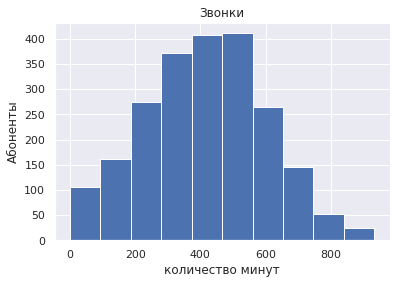

count   2,220.00
mean      414.87
std       185.77
min         0.00
25%       281.75
50%       421.00
75%       544.00
max       933.00
Name: total_minute, dtype: float64
34510.24800778696


In [33]:
smart_user['total_minute'].plot(kind='hist', bins=10)
plt.title('Звонки')
plt.xlabel('количество минут')
plt.ylabel('Абоненты')
plt.show()
print(smart_user['total_minute'].describe())
print(np.var(smart_user['total_minute'], ddof=1))

60 % абонентов не выходит за рамки 500 минут

### *Сообщения*

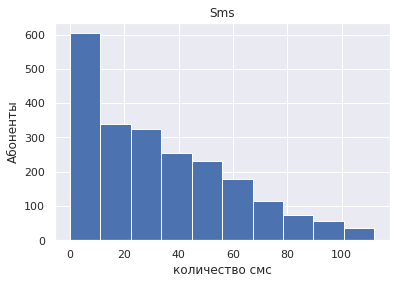

count   2,216.00
mean       32.77
std        27.28
min         0.00
25%        10.00
50%        28.00
75%        50.00
max       112.00
Name: total_sms, dtype: float64

In [34]:
smart_user['total_sms'].plot(kind='hist', bins=10)
plt.title('Sms')
plt.xlabel('количество смс')
plt.ylabel('Абоненты')
plt.show()
smart_user['total_sms'].describe()

Услуга смс сообщений не пользуется популярностью, 75% пользователей не выходит за рамки тарифа

### *Интернет*

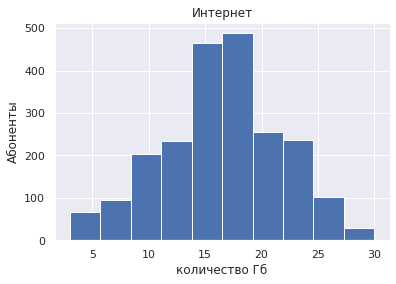

count   2,176.00
mean       16.43
std         5.27
min         3.00
25%        13.00
50%        17.00
75%        20.00
max        30.00
Name: total_mb, dtype: float64

In [35]:
smart_user['total_mb'].plot(kind='hist', bins=10)
plt.title('Интернет')
plt.xlabel('количество Гб')
plt.ylabel('Абоненты')
plt.show()
smart_user['total_mb'].describe()

Интернета абонентам тарифа смарт не хватает. Примерно 55%  пользователям приходиться докупать мегабайты. 

### *Выручка*

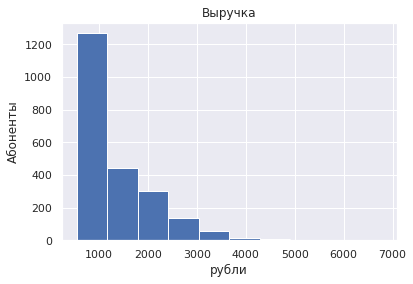

count   2,230.00
mean    1,289.64
std       818.37
min       550.00
25%       550.00
50%     1,021.00
75%     1,750.00
max     6,770.00
Name: revenue, dtype: float64

In [36]:
smart_user['revenue'].plot(kind='hist', bins= 10)
plt.title('Выручка')
plt.xlabel('рубли')
plt.ylabel('Абоненты')
plt.show()
smart_user['revenue'].describe()

По распределению выручки видно, что только 25% пользователей укладываются в абонентскую плату. 50% превышают лимит в два раза и 75 % аж в три раза! 

### Пользователи тарифа ultra	

In [37]:
ultra_user = df.query('tariff == "ultra"')
display(ultra_user)

,index,user_id,month,total_minute,total_calls,total_sms,total_mb,total_session,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,0,1000,5,159,22,22,3,5,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
1,1,1000,6,172,43,60,23,49,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
2,2,1000,7,340,47,75,14,29,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
3,3,1000,8,408,52,81,14,29,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
4,4,1000,9,466,58,57,15,27,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,3205,1473,9,0,0,19,17,34,18,0,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1,1950
3206,3206,1473,10,0,0,20,14,32,18,0,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1,1950
3207,3207,1473,11,0,0,14,22,41,18,0,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1,1950
3208,3208,1473,12,0,0,20,18,31,18,0,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1,1950


In [38]:
def quartil(ultra_user, column):
    q1 = ultra_user[column].quantile(0.25)
    q3 = ultra_user[column].quantile(0.75)
    iqr = q3 - q1
    dfq = ultra_user.loc[(ultra_user[column] < q3 + 1.5*iqr) & (ultra_user[column] > q1 - 1.5*iqr), column]
    return dfq

columns = ['total_minute','total_sms', 'total_mb']
for row in columns:
    ultra_user[row] = quartil(ultra_user, row)
ultra_user.describe()

/tmp/ipykernel_372/1680168109.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultra_user[row] = quartil(ultra_user, row)
/tmp/ipykernel_372/1680168109.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultra_user[row] = quartil(ultra_user, row)
/tmp/ipykernel_372/1680168109.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,index,user_id,month,total_minute,total_calls,total_sms,total_mb,total_session,age,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
count,986.00,986.00,986.00,984.00,986.00,977.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00
mean,"1,722.65","1,262.96",8.24,523.82,73.32,47.91,19.47,38.39,46.84,"1,000.00","30,720.00","3,000.00","1,950.00",150.00,1.00,1.00,"2,070.03"
std,918.46,140.69,2.88,314.20,43.96,45.70,9.87,19.65,17.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,376.02
min,0.00,"1,000.00",0.00,0.00,0.00,0.00,0.00,0.00,18.00,"1,000.00","30,720.00","3,000.00","1,950.00",150.00,1.00,1.00,"1,950.00"
25%,935.25,"1,143.00",6.00,282.00,41.00,6.00,12.00,24.00,30.00,"1,000.00","30,720.00","3,000.00","1,950.00",150.00,1.00,1.00,"1,950.00"
50%,"1,833.50","1,277.00",9.00,517.00,73.50,37.00,19.00,38.00,45.00,"1,000.00","30,720.00","3,000.00","1,950.00",150.00,1.00,1.00,"1,950.00"
75%,"2,436.75","1,381.00",11.00,751.00,103.75,77.00,27.00,52.00,63.00,"1,000.00","30,720.00","3,000.00","1,950.00",150.00,1.00,1.00,"1,950.00"
max,"3,214.00","1,495.00",12.00,"1,410.00",244.00,185.00,49.00,97.00,75.00,"1,000.00","30,720.00","3,000.00","1,950.00",150.00,1.00,1.00,"4,800.00"


### *Звонки*

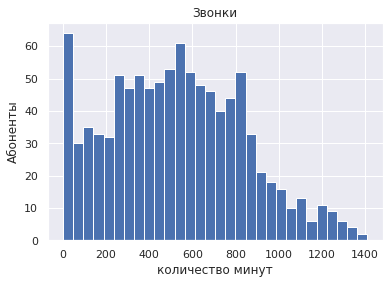

count     984.00
mean      523.82
std       314.20
min         0.00
25%       282.00
50%       517.00
75%       751.00
max     1,410.00
Name: total_minute, dtype: float64

In [39]:
ultra_user['total_minute'].plot(kind='hist', bins=30)
plt.title('Звонки')
plt.xlabel('количество минут')
plt.ylabel('Абоненты')
plt.show()
ultra_user['total_minute'].describe()

Абоненты тарифа «Ультра» не выговаривают половины купленных минут.

### *Сообщения*

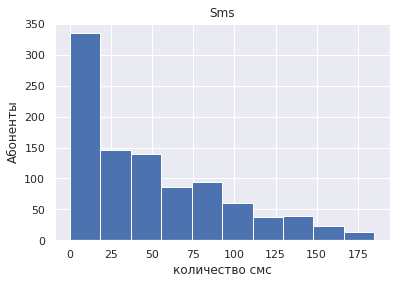

count   977.00
mean     47.91
std      45.70
min       0.00
25%       6.00
50%      37.00
75%      77.00
max     185.00
Name: total_sms, dtype: float64

In [40]:
ultra_user['total_sms'].plot(kind='hist', bins=10)
plt.title('Sms')
plt.xlabel('количество смс')
plt.ylabel('Абоненты')
plt.show()
ultra_user['total_sms'].describe()

Смс тоже покупается с большим излишком

### *Интернет*

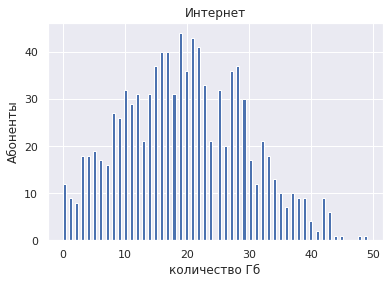

count   986.00
mean     19.47
std       9.87
min       0.00
25%      12.00
50%      19.00
75%      27.00
max      49.00
Name: total_mb, dtype: float64

In [41]:
ultra_user['total_mb'].plot(kind='hist', bins= 100)
plt.title('Интернет')
plt.xlabel('количество Гб')
plt.ylabel('Абоненты')
plt.show()
ultra_user['total_mb'].describe()

75 % клиентов тарифа «Ультра» укладываются в купленный трафик, остальные 25% доплачивают. 

### *Выручка*

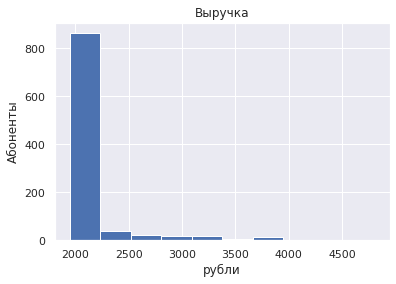

count     986.00
mean    2,070.03
std       376.02
min     1,950.00
25%     1,950.00
50%     1,950.00
75%     1,950.00
max     4,800.00
Name: revenue, dtype: float64

In [42]:
ultra_user['revenue'].plot(kind='hist', bins= 10)
plt.title('Выручка')
plt.xlabel('рубли')
plt.ylabel('Абоненты')
plt.show()
ultra_user['revenue'].describe()

Распределение выручки в тарифе «Ультра» показывает нам, что основная часть пользователей не выход за рамки абонентской платы.

### **Итог по блоку:**

Вывод:  
* Любителям поболтать тариф «Смарт» не совсем подходит, 40% доплачивают за минуты разговора.  
А тариф «Ультра» подойдёт что бы обсудить по телефону любимые темы и ещё останется половина.  
* Для 25% абонентов тарифа «Смарт» можно добавить количество сообщений, в «Ультра» смс можно убавить на ¾.  
Но в целом услугой пользуются не активно там и там.  
* Интернета не хватает пользователям «Смарт» здесь большая часть доплачивает – 55%.  
А в тарифе «Ультра» 25% выходят за рамки оплаченного.   


Выручка:
* Тариф «Смарт»  
Среднее = 1,289.64   
Стандартное отклонение = 816.74

* Тариф «Ультра»  
Среднее =  2,070.03  
Стандартное отклонение = 374.51



    

### **Дисперсия**

Изучаем разницу разброса данных двух тарифов по выручке, звонкам, смс и Гб

In [43]:
# Смарт
x = ['total_minute','total_sms','total_mb','revenue'] # выборка
def var_x (row):
    return np.var(x, ddof=1)
smart_var = smart_user.pivot_table(index = 'tariff',values = ['total_minute','total_sms','total_mb','revenue'], aggfunc = 'var' )


In [44]:
# Ультра
x = ['total_minute','total_sms','total_mb','revenue'] # выборка
def var_x (row):
    return np.var(x, ddof=1)
ultra_var = ultra_user.pivot_table(index = 'tariff',values = ['total_minute','total_sms','total_mb','revenue'], aggfunc = 'var' )

In [45]:
# Сравниваем
tariffs_var = pd. concat([smart_var,ultra_var],sort=False,axis = 0)
display(tariffs_var)

,revenue,total_mb,total_minute,total_sms
tariff,,,,
smart,"669,730.76",27.81,"34,510.25",744.27
ultra,"141,387.71",97.38,"98,721.82","2,088.51"


Если смотреть на такие метрики как звонки, смс и количество потраченных Гб, то увидим, что в тарифе «Ультра» разброс больше.  
В целом это очевидно, в «Ультра» доступных единиц по опциям намного больше чем в «Смарт», следовательно вариативность их использования тоже увеличивается.   
А вот дисперсия по выручке больше в «Смарт». Вероятно из за того, что большинству абонентам приходиться постоянно доплачивать за ту или иную опцию. В «Ультра» с этим более стабильно.


Я пыталась добавить сюда сравнительную гистограмму.Получилась ерунда.


## **Проверка гипотез**

### Гипотеза №1

* H0: Средняя выручка пользователей тарифов «Ультра» и «Смарт» **одинакова**.  
* H1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» **различаются**.


In [46]:
# сопоставляем среднее двух выборок, используем st.ttest_ind
alpha = 0.05
results = st.ttest_ind(smart_user['revenue'], ultra_user['revenue'])
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 8.081909555489933e-161
Отвергаем нулевую гипотезу


Т.е Средняя выручка пользователей тарифов «Ультра» и «Смарт» **различаются**.


### Гипотеза №2

* H0: Средняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов.  
* H1: Средняя выручка пользователей из Москвы **отличается** от выручки пользователей из других регионов.

In [47]:
other_region = df[df['city'] != 'Москва']


In [48]:
moscow = df[df['city'] == 'Москва']


In [49]:
# тут тоже две выборки, тоже использую st.ttest_ind
city_revenue = st.ttest_ind(other_region['revenue'], moscow['revenue'])
print('p-значение:', city_revenue.pvalue)
if city_revenue.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.', results.pvalue)

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу. 8.081909555489933e-161


Абоненты  Москвы и других регионов примерно одинаково приносят прибыль компании 

## **Вывод**

 **В ходе подготовки данных было подсчитано:**  

* количество израсходованных минут разговора;  
* количество отправленных сообщений;  
* объем израсходованного интернет-трафика;  
* помесячную выручку с каждого пользователя 

**Из этих данных сделали вывод:**
* Тариф «Смарт» не совсем подходит тем, кто часто и много говорит по телефону, 40% пользователей доплачивают за минуты разговора.  А в тарифе «Ультра» половина пакетных минут остаётся не расходованной 
* Для 25% абонентов тарифа «Смарт» можно добавить количество сообщений, в «Ультра» смс можно убавить на ¾.  
Но в целом услугой пользуются не активно там и там.  
* Интернета не хватает пользователям «Смарт», 55% абонентов доплачивают за гигабайты. А в тарифе «Ультра» за рамки оплаченного выходят 25%.  
 

**Выручка:**
* Тариф «Смарт»  
Среднее = 1,289.64   
Стандартное отклонение = 816.74

* Тариф «Ультра»  
Среднее = 2,070.03  
Стандартное отклонение = 374.51  

**Дисперсия**  
 Если смотреть на такие метрики как звонки, смс и количество потраченных Гб, то увидим, что в тарифе «Ультра» разброс больше.  
А вот дисперсия по выручке больше в «Смарт». Вероятно, из-за того, что большинству абонентам приходиться постоянно доплачивать за ту или иную опцию. В «Ультра» с этим более стабильно. 

**Москва и другие области**  
 Также сравнили среднюю прибыль, которую приносят абоненты Москвы и абоненты других регионов вместе.  И выяснили, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.  
Из анализа данных делаем вывод, что тариф «Ультра» выгодней и удовлетворяет потребностям большинства пользователей.   

***Тариф «Смарт» уступает тарифу «Ультра» по всем критериям. Он не удобен для пользователей т.к. часто приходиться доплачивать за ту или иную услугу. И менее выгоден для оператора. Поэтому стоит пересмотреть опции для данного тарифа или поменять его в корне: увеличить количество минут для звонков, добавить гигабайты и, следовательно, придётся поднять цену. В результате можем получить новый тариф, что то между старым "Смарт" и "Ультра"***  

***Тариф «Ультра» изменять не стоит если резерв 3000 минут и 1000 сообщений не несёт какой-либо нагрузки. Несмотря на то, что здесь не используется весь потенциал, абонентам не понравиться если чего-то станет меньше.*** 

